In [1]:
## Normalize pixel values
import torch

In [40]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [116]:
plt.rcParams['image.cmap'] = 'gray'

In [119]:
from torchvision import datasets
from torchvision.transforms import transforms

In [120]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_set = datasets.MNIST('mnist/', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Extracting mnist/MNIST\raw\train-images-idx3-ubyte.gz to mnist/MNIST\raw


Extracting mnist/MNIST\raw\train-labels-idx1-ubyte.gz to mnist/MNIST\raw



Extracting mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to mnist/MNIST\raw


Extracting mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist/MNIST\raw
Processing...


C:\Users\csshr\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [122]:
for d in test_loader:
    print(d[0].shape)
    break

torch.Size([64, 1, 28, 28])


In [3]:
data_points = []
class_labels = []

with open('Data/mnist_train_file.txt') as fs:
    for line in fs:
        data = list(map(int, line.strip().split(','))) 
        label = data[0]
        datapoint = data[1:]
        data_points.append(datapoint)
        class_labels.append(label)

In [4]:
print(len(data_points))

60000


In [5]:
len(data_points[0]) ## 28 x 28 = 784

784

In [6]:
class Mnist_dataset(Dataset):
    def __init__(self, data_points, class_labels):
        super(Dataset, self).__init__()
        self.data = data_points
        self.labels = class_labels
    
    def __len__(self):
        # returns length of the dataset
        return len(self.labels)
    
    def __getitem__(self, index):
        # retrieves an item of a given index
        d = torch.FloatTensor(self.data[index])
        l = torch.LongTensor([self.labels[index]])
        return d,l

In [41]:
mnist_data = Mnist_dataset(data_points, class_labels)

In [91]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [92]:
G = generator()

In [93]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [94]:
D = discriminator()

In [95]:
epochs = 10
lr = 0.0002
batch_size = 64
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [96]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(1, 128)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0

In [97]:
train_dataloader = DataLoader(mnist_data, batch_size=batch_size)

In [124]:
# Training Loop
# Code adopted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        d_optimizer.zero_grad()
        # Format batch
        real_data = data[0].squeeze(1).reshape(batch_size, -1)
        #print(real_data.shape)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        #print(real_data.shape)
        output = D(real_data).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        #print(errD_real)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        #print(fake.shape)
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        d_optimizer.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        g_optimizer.step()
        
        # Output training stats
        #if i % 50 == 0:
        #    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        #          % (epoch, epochs, i, len(train_dataloader),
        #             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())     
        




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Starting Training Loop...
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

  0%|                                                                                           | 0/10 [00:23<?, ?it/s]

torch.Size([64, 784])


KeyboardInterrupt: 

In [111]:
fixed_noise = torch.randn(1, 128)

In [112]:
fake = G(fixed_noise).detach()

In [114]:
img = fake.reshape(28, 28)

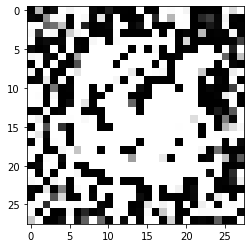

In [117]:
plt.imshow(img.numpy())